https://www.cienciadedatos.net/documentos/py29-forecasting-demanda-energia-electrica-python.html

Cuando se trabaja con series temporales, raramente se quiere predecir solo el siguiente elemento de la serie (*t+1*), sino todo un intervalo futuro o un punto alejado en el tiempo (*t+n*). A cada paso de predicción se le conoce como step. Existen varias estrategias que permiten generar este tipo de predicciones múltiples:

**Recursive multi-step forecasting**

Dado que, para predecir el momento  tn  se necesita el valor de *tn−1*, y *tn−1* se desconoce, es necesario hacer predicciones recursivas en las que, cada nueva predicción, se basa en la predicción anterior. A este proceso se le conoce como *recursive forecasting* o *recursive multi-step forecasting*.

La principal adaptación que se necesita hacer para aplicar modelos de scikit learn a problemas de *recursive multi-step forecasting* es transformar la serie temporal en un matriz en la que, cada valor, está asociado a la ventana temporal (lags) que le precede.

**Direct multi-step forecasting**

El método *direct multi-step forecasting* consiste en entrenar un modelo distinto para cada *step*. Por ejemplo, si se quieren predecir los siguientes 5 valores de una serie temporal, se entrenan 5 modelos distintos, uno para cada *step*. Como resultado, las predicciones son independientes unas de otras.

La principal complejidad de esta aproximación consiste en generar correctamente las matrices de entrenamiento para cada modelos. Todo este proceso está automatizado en la clase `ForecasterAutoregMultiOutput` de la librería **skforecast**. También es importante tener en cuenta que esta estrategia tiene un coste computacional más elevado ya que requiere entrenar múltiples modelos. En el siguiente esquema se muestra el proceso para un caso en el que se dispone de la variable respuesta y dos variables exógenas.

**Multiple output forecasting**

Determinados modelos son capaces de predecir de forma simultánea varios valores de una secuencia (*one-shot*). Un ejemplo de modelo con esta capacidad son las redes neuronales LSTM.

-----

**Caso de uso**

Se dispone de una serie temporal con la demanda eléctrica (MW) del estado de Victoria (Australia) desde 2011-12-31 al 2014-12-31. Se pretende generar un modelo de forecasting capaz de predecir la demanda energética del día siguiente a nivel horario.

# Librerias

In [3]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

# Datos

- Time: fecha y hora del registro.
- Date: fecha del registro
- Demand: demanda de electricidad MW.
- Temperature: temperatura en Melbourne, capital del estado de Victoria.
- Holiday: indicador si el día es festivo (vacaciones).

In [4]:
# Descarga de datos
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
datos = pd.read_csv(url, sep=',')
print(datos.info())
datos.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB
None


,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True


In [5]:
datos["Time"] = pd.to_datetime(datos["Time"], format='%Y-%m-%dT%H:%M:%SZ')
datos = datos.set_index("Time")
datos = datos.asfreq('30min')
datos = datos.sort_index()
datos.head(3)

,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True


Uno de los primeros análisis que hay que realizar al trabajar con series temporales es verificar si la serie está completa.

In [6]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

True

In [7]:
# Completar huecos en un índice temporal
# ==============================================================================
# datos.asfreq(freq='30min', fill_value=np.nan)

Aunque los datos se encuentran en intervalos de 30 minutos, el objetivo es crear un modelo capaz de predecir la demanda eléctrica a nivel horario, por lo que se tienen que agregar los datos. Este tipo de transformación es muy sencillas si se combina el índice de tipo temporal de pandas y su método `resample()`.

Es muy importante utilizar correctamente los argumentos `closed='left'` y `label='right'` para no introducir en el entrenamiento información a futuro (leakage). Supóngase que se dispone de valores para las 10:10, 10:30, 10:45, 11:00, 11:12 y 11:30. Si se quiere obtener el promedio horario, el valor asignado a las 11:00 debe calcularse utilizando los valores de las 10:10, 10:30 y 10:45; y el de las 12:00, con el valor de las 11:00, 11:12 y 11:30.

Para el valor promedio de las 11:00 no se incluye el valor puntual de las 11:00 por que, en la realidad, en ese momento exacto no se dispone todavía del valor.

In [8]:
# Agregado en intervalos de 1H
# ==============================================================================
# Se elimina la columna Date para que no genere error al agregar. La columna Holiday
# no genera error ya que es booleana y se trata como 0-1.
datos = datos.drop(columns='Date')
datos = datos.resample(rule='H', closed='left', label ='right').mean()
datos

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,True
2011-12-31 15:00:00,3963.264688,20.625,True
2011-12-31 16:00:00,3950.913495,20.325,True
2011-12-31 17:00:00,3627.860675,19.850,True
2011-12-31 18:00:00,3396.251676,19.025,True
...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,False
2014-12-31 10:00:00,3909.230704,20.300,False
2014-12-31 11:00:00,3900.600901,19.650,False


El set de datos empieza el 2011-12-31 14:00:00 y termina el 2014-12-31 13:00:00. Se descartan los primeros 10 y los últimos 13 registros para que empiece el 2012-01-01 00:00:00 y termine el 2014-12-30 23:00:00. Además, para poder optimizar los hiperparámetros del modelo y evaluar su capacidad predictiva, se dividen los datos en 3 conjuntos, uno de entrenamiento, uno de validación y otro de test.

In [9]:
# Separación datos train-val-test
# ==============================================================================
datos = datos.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
fin_train = '2013-12-31 23:59:00'
fin_validacion = '2014-11-30 23:59:00'
datos_train = datos.loc[:fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}")

Fechas train      : 2012-01-01 00:00:00 --- 2013-12-31 23:00:00
Fechas validacion : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00
Fechas test       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00


# Exploración gráfica

## Serie temporal completa

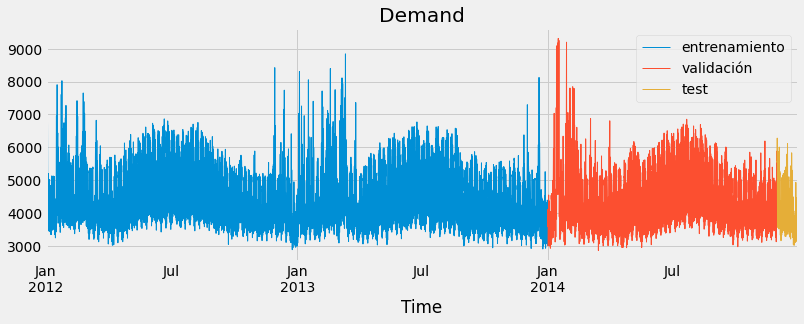

In [22]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
datos_train.Demand.plot(ax=ax, label='entrenamiento', linewidth=1)
datos_val.Demand.plot(ax=ax, label='validación', linewidth=1)
datos_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Demand')
ax.legend()
plt.show();

El gráfico anterior muestra que la demanda eléctrica tiene estacionalidad anual. Se observa un incremento centrado en el mes de Julio y picos de demanda muy acentuados entre enero y marzo.

**Sección de la serie temporal**

Debido a la varianza de la serie temporal, no es posible apreciar con un solo gráfico el posible patrón intradiario.

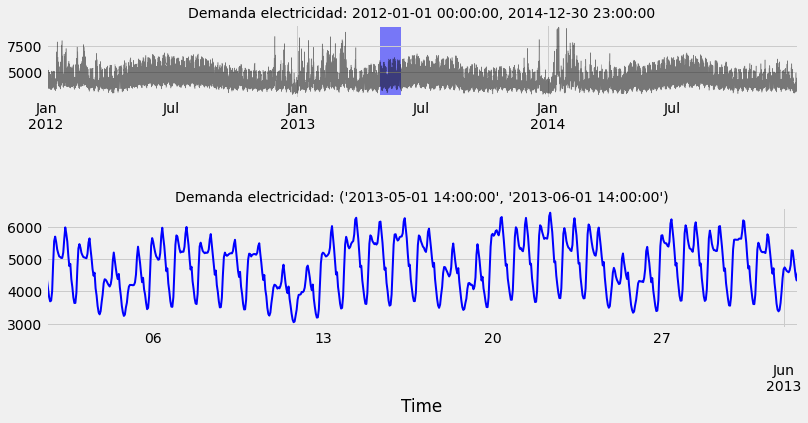

In [11]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2013-05-01 14:00:00','2013-06-01 14:00:00')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos.Demand.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(datos.Demand)
max_y = max(datos.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

datos.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Demanda electricidad: {datos.index.min()}, {datos.index.max()}', fontsize=14)
zoom_ax.set_title(f'Demanda electricidad: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)
plt.show();

Al aplicar zoom sobre la serie temporal, se hace patente una clara estacionalidad semanal, con consumos más elevados durante la semana laboral (lunes a viernes) y menor en los fines de semana. Se observa también que existe una clara correlación entre el consumo de un día con el del día anterior.

## Estacionalidad anual, semanal y diaria

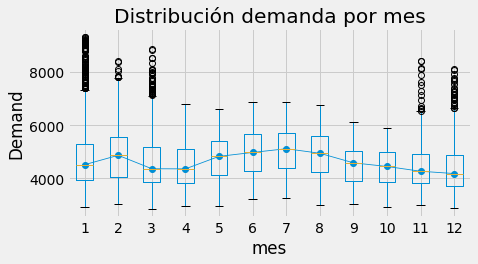

In [12]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['mes'] = datos.index.month
datos.boxplot(column='Demand', by='mes', ax=ax,)
datos.groupby('mes')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes')
fig.suptitle('')
plt.show();

Se observa que hay una estacionalidad anual, con valores de demanda (mediana) superiores en los meses de Junio, Julio y Agosto, y con elevados picos de demanda en los meses de Noviembre, Diciembre, Enero, Febrero y Marzo.

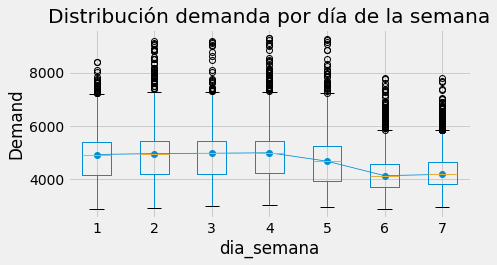

In [13]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['dia_semana'] = datos.index.day_of_week + 1
datos.boxplot(column='Demand', by='dia_semana', ax=ax)
datos.groupby('dia_semana')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por día de la semana')
fig.suptitle('')
plt.show();

Se aprecia una estacionalidad semanal, con valores de demanda inferiores durante el fin de semana.

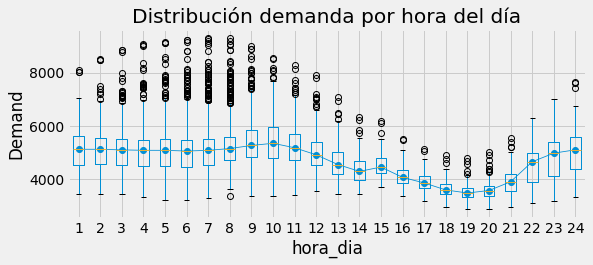

In [14]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
datos['hora_dia'] = datos.index.hour + 1
datos.boxplot(column='Demand', by='hora_dia', ax=ax)
datos.groupby('hora_dia')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por hora del día')
fig.suptitle('')
plt.show();

También existe una estacionalidad diaria, la demanda se reduce entre las 16 y las 21 horas.

## Días festivos y no festivos

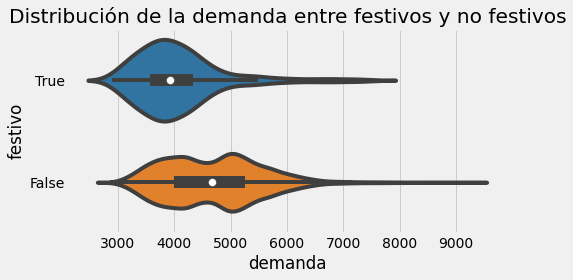

In [15]:
# Grafico violinplot
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = 'Demand',
    y       = 'Holiday',
    data    = datos.assign(Holiday = datos.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('festivo')
plt.show();

Los días festivos tienden a tener menor consumo.

## Gráficos de autocorrelación

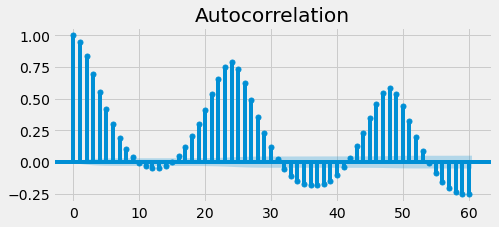

In [16]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(datos.Demand, ax=ax, lags=60)
plt.show();

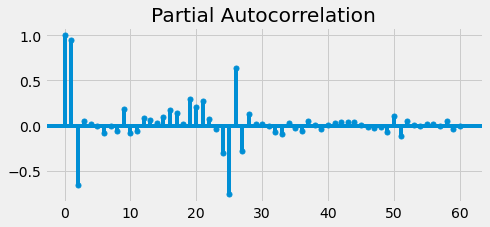

In [17]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(datos.Demand, ax=ax, lags=60)
plt.show();

Los gráficos de autocorrelación y autocorrelación parcial muestran una clara asociación entre la demanda de una hora y las horas anteriores, así como entre la demanda de una hora y la demanda de esa misma hora los días anteriores. Este tipo de correlación, es un indicativo de que los modelos autorregresivos pueden funcionar bien.

# Modelo autoregresivo recursivo

## Entrenamiento

Se crea y entrena un modelo autorregresivo recursivo (`ForecasterAutoreg`) a partir de un modelo de **regresión lineal con penalización Ridge** y una ventana temporal de 24 lags. Esto último significa que, para cada predicción, se utilizan como predictores la demanda de las 24 horas anteriores.

In [18]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(normalize=True),
                lags      = 24
             )

forecaster.fit(y=datos.loc[:fin_validacion, 'Demand'])
forecaster

=======================ForecasterAutoreg=======================
Regressor: Ridge(normalize=True)
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Exogenous variable: False, None
Parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': True, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

Se evalúa el comportamiento que habría tenido el modelo si se hubiese entrenado con los datos desde 2012-01-01 00:00 al 2014-11-30 23:59 y, después, a las 23:59 de cada día, se predijesen las 24 horas siguientes. A este tipo de evaluación se le conoce como **backtesting**, y puede aplicarse fácilmente con la función `backtesting_forecaster()`. Esta función devuelve, además de las predicciones, una métrica de error.

In [19]:
# Backtest
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos.Demand,
                            initial_train_size = len(datos.loc[:fin_validacion]),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

# Se añade el índice temporal a las predicciones
predicciones = pd.Series(data=predicciones, index=datos[fin_validacion:].index)

Number of observations used for training: 25560
Number of observations used for testing: 720
    Number of folds: 30
    Number of steps per fold: 24


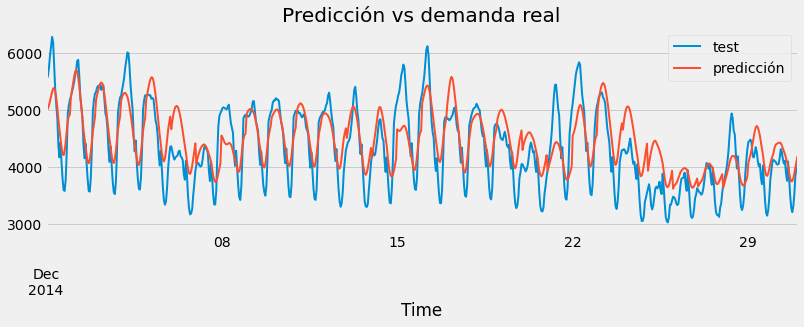

In [20]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend()
plt.show();

In [23]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

Error backtest: [363.06587567]


## Optimización de hiperparámetros (tuning)

En el objeto `ForecasterAutoreg` entrenado, se han utilizado los primeros 24 lags y un modelo **Ridge** con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados.

Con el objetivo de identificar la mejor combinación de lags e hiperparámetros, se recurre a un *Grid Search* con validación por *backtesting*. Este proceso consiste en entrenar un modelo con cada combinación de hiperparámetros y lags, y evaluar su capacidad predictiva mediante **backtesting**. En el proceso de búsqueda es importante evaluar los modelos utilizando únicamente los datos de validación y no incluir los de test, estos se utilizan solo en último lugar para evaluar al modelo final.

In [24]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = Ridge(normalize=True),
                    lags      = 24 # Este valor será remplazado en el grid search
              )

# Hiperparámetros del regresor
param_grid = {'alpha': np.logspace(-3, 3, 10)}

# Lags utilizados como predictores
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos.loc[:fin_validacion, 'Demand'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        metric      = 'mean_absolute_error',
                        method      = 'backtesting',
                        initial_train_size = len(datos[:fin_train]),
                        return_best = True,
                        verbose     = False
                  )

2021-10-06 13:31:38,455 root       INFO  Number of models compared: 30
loop lags_grid: 100%|████████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.87s/it]
2021-10-06 13:31:59,252 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3 23 24 25 47 48 49] 
params: {'alpha': 0.004641588833612777}



In [25]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,metric,alpha
21,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.004641588833612777},269.698640,0.004642
22,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.021544346900318832},271.108777,0.021544
20,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.001},296.636751,0.001000
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.001},330.635873,0.001000
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.004641588833612777},344.364905,0.004642
23,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.1},359.323464,0.100000
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.021544346900318832},372.113405,0.021544
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},396.836961,0.100000
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.46415888336127775},411.305373,0.464159
24,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.46415888336127775},428.373252,0.464159


Los mejores resultados se obtienen si se utilizan los lags **[1, 2, 3, 23, 24, 25, 47, 48, 49]** y una configuración de **Ridge {'alpha': 0.004642}**. Al indicar `return_best = True` en la función `grid_search_forecaster()`, al final del proceso, se reentrena automáticamente el objeto forecaster con la mejor configuración encontrada y el set de datos completo.

In [26]:
forecaster

=======================ForecasterAutoreg=======================
Regressor: Ridge(alpha=0.004641588833612777, normalize=True)
Lags: [ 1  2  3 23 24 25 47 48 49]
Exogenous variable: False, None
Parameters: {'alpha': 0.004641588833612777, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': True, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

## Backtest con el conjunto de test

Una vez identificado y entrenado el mejor modelo, se calcula su error al predecir los datos de test.

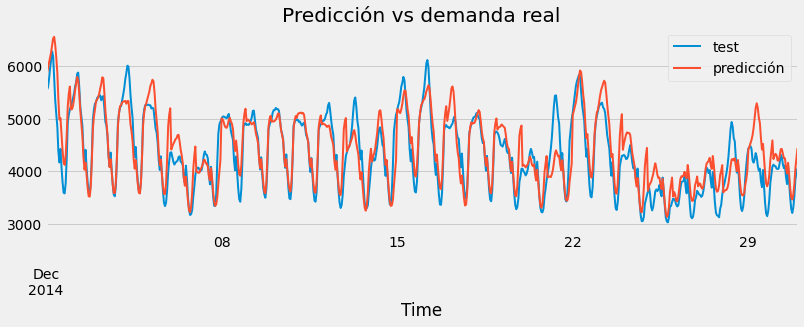

In [27]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos.Demand,
                            initial_train_size = len(datos[:fin_validacion]),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            verbose    = False
                        )

# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos[fin_validacion:].index)

fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend()
plt.show();

In [28]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

Error backtest: [260.86993041]


Tras la optimización de lags e hiperparámetros, se ha conseguido reducir el error de predicción de 363 a 261.

## Intervalos de predicción